**Universidad Politécnica Salesiana***

**Carrera de Ciencias de la Computación**

**Proyecto Integrador Visión por Computadora y Machine Learning**

**Integrantes:** Christian Naranjo, Sara Quiguango, Zelena Jiménez, Leandro Lara

**Nivel:** 9

**Fecha:** 31/07/2024

IMAGENES


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Mostrando imágenes en '/content/drive/My Drive/DATASET ALQUERQUE/Permitidas/':


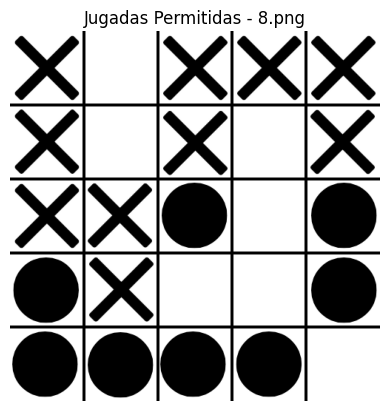

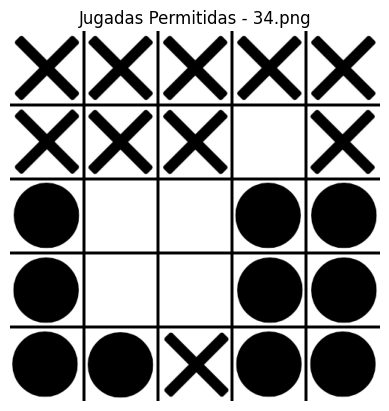

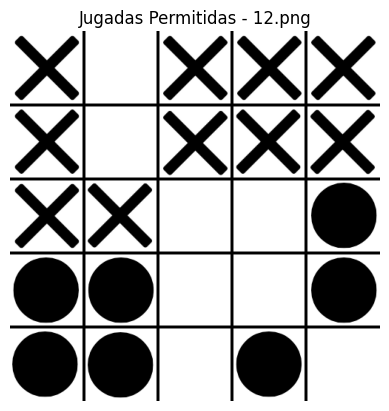

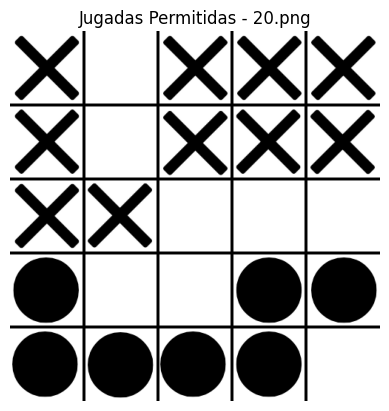

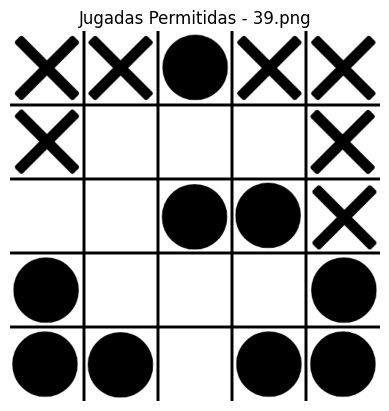

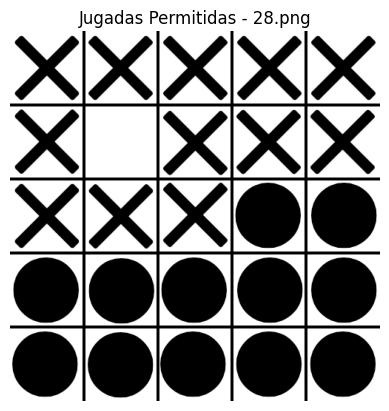

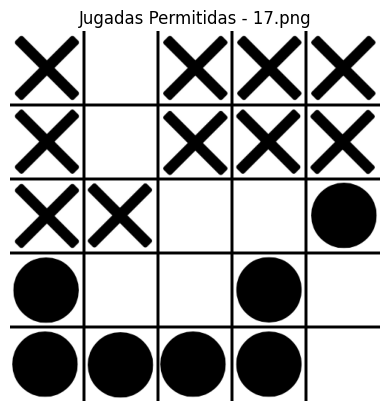

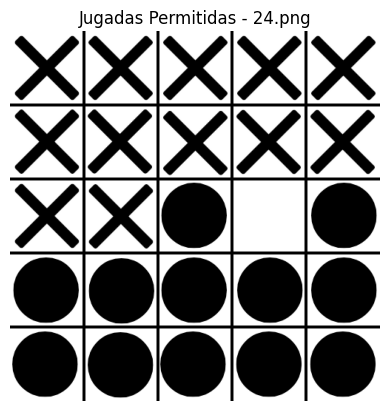

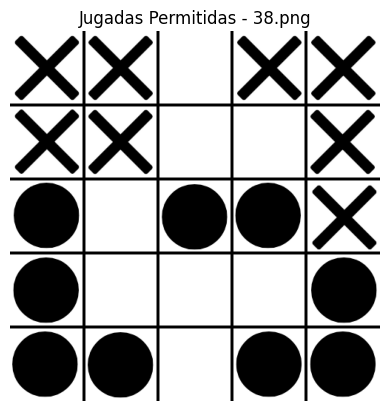

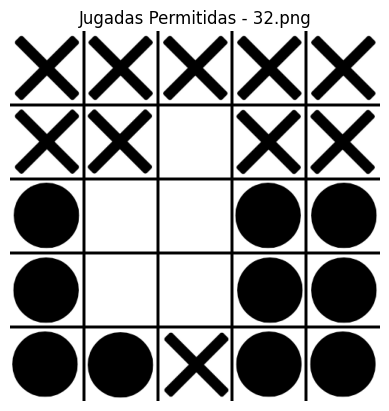

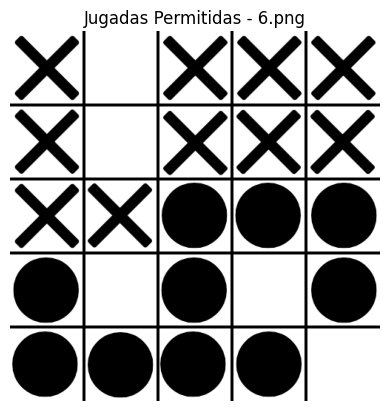

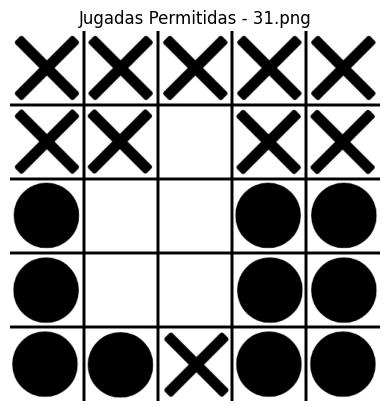

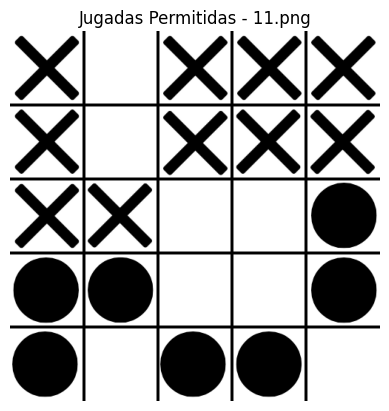

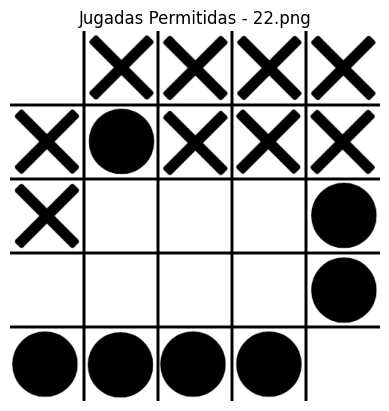

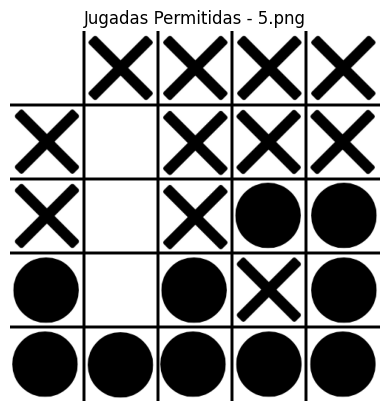

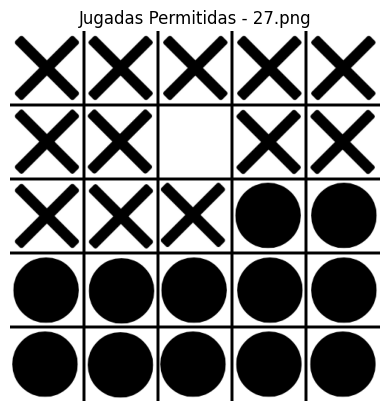

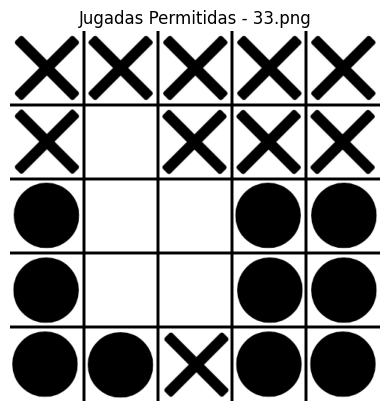

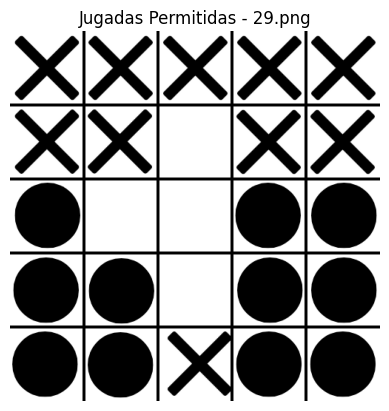

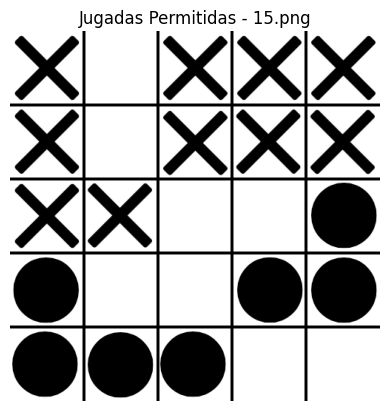

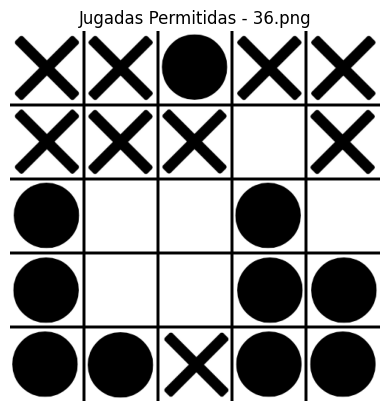

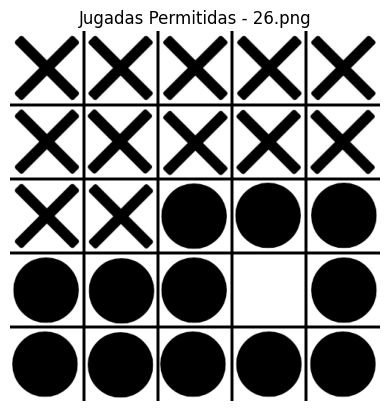

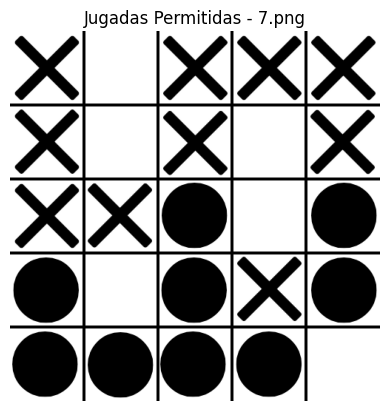

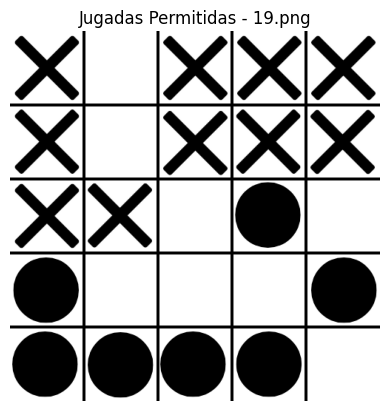

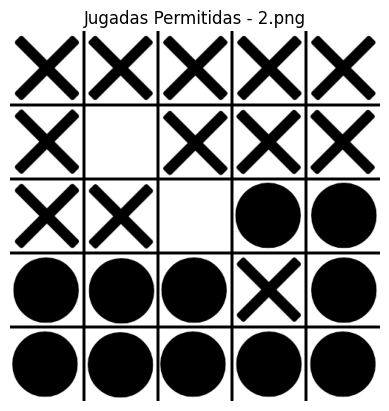

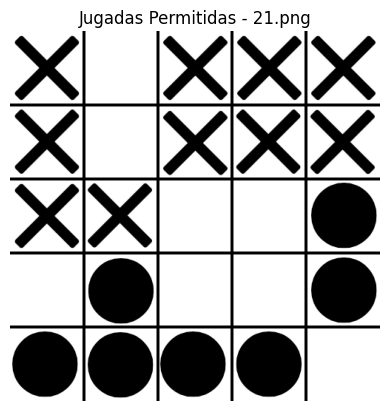

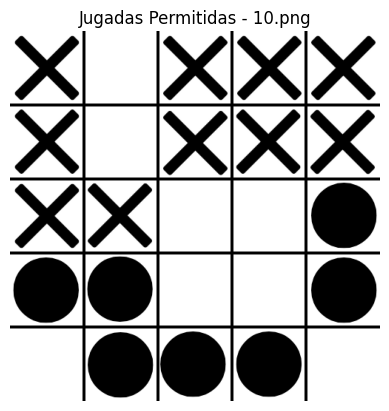

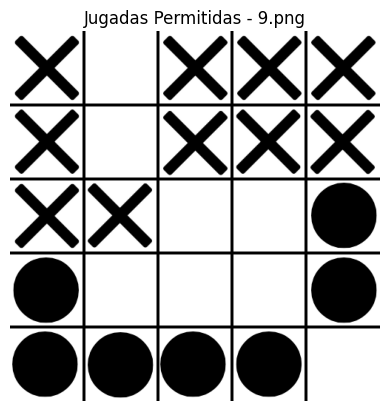

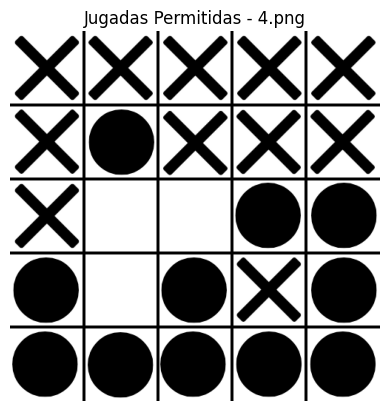

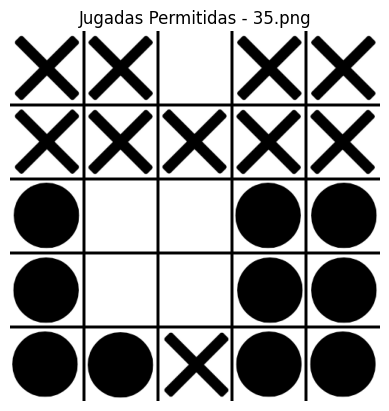

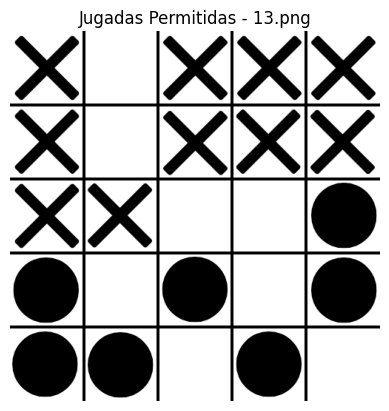

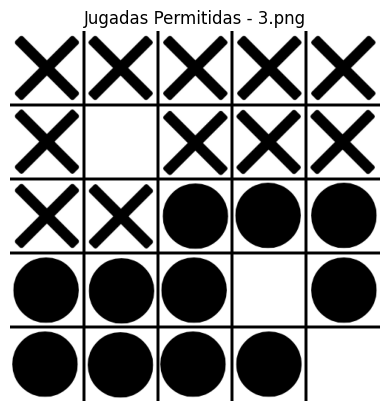

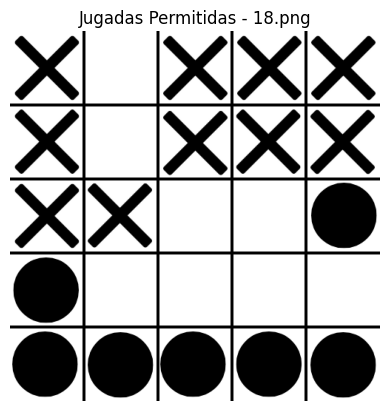

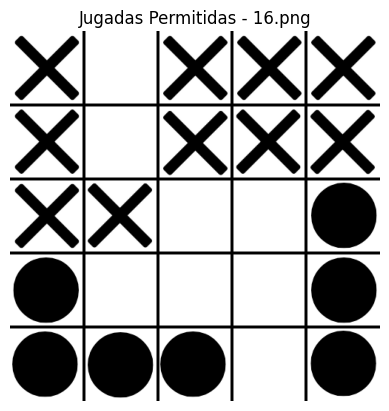

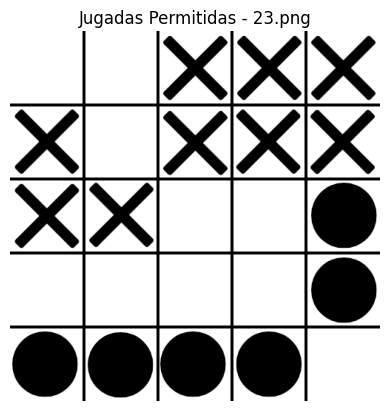

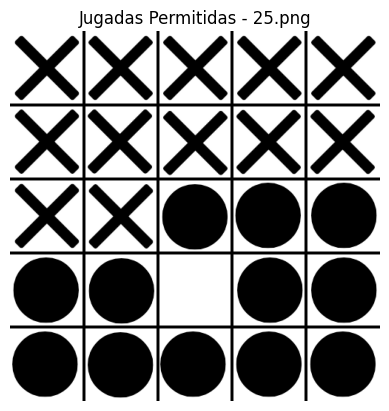

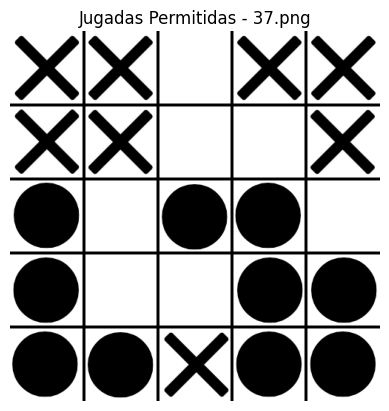

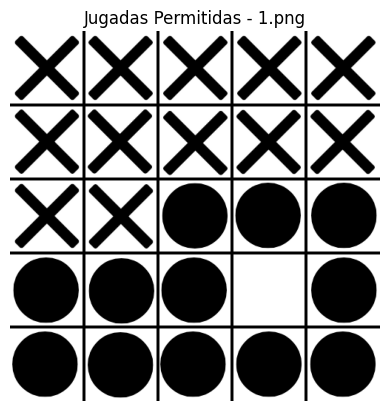

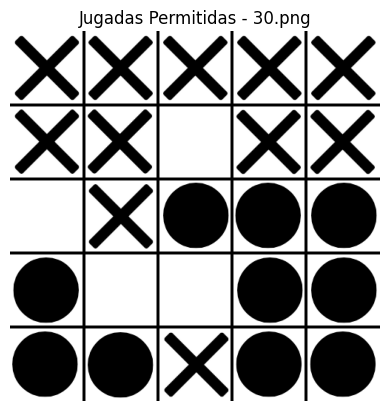

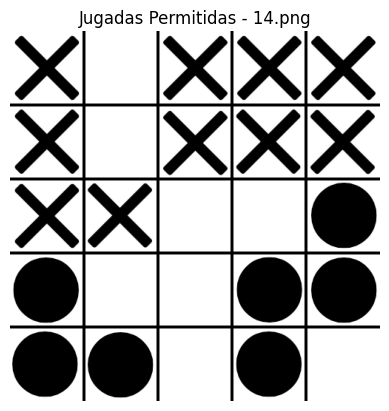

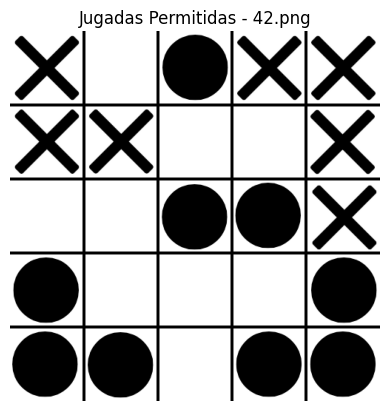

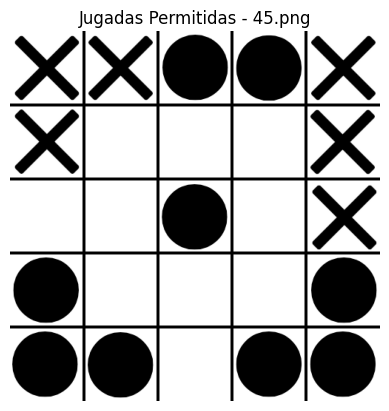

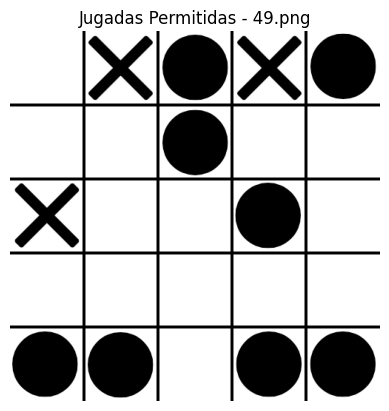

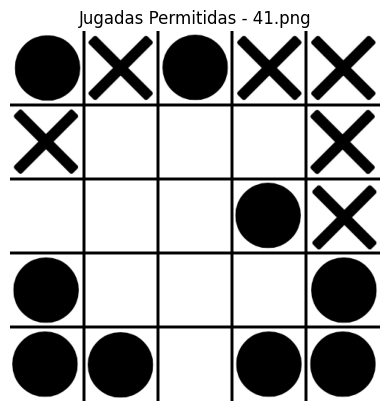

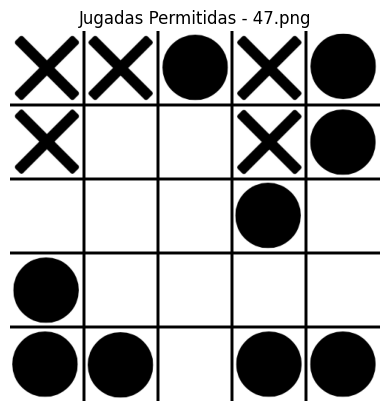

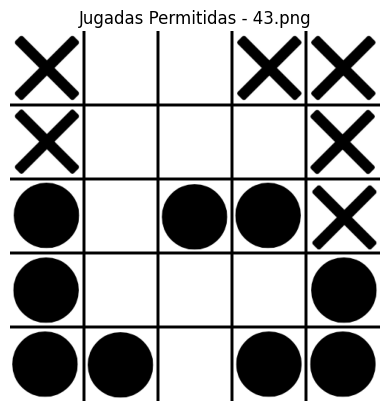

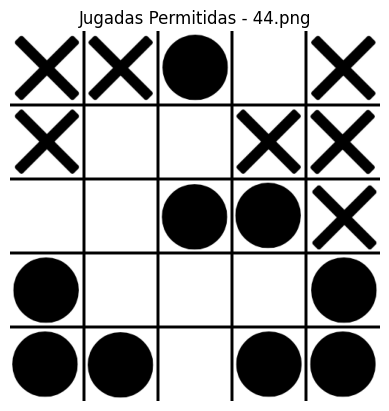

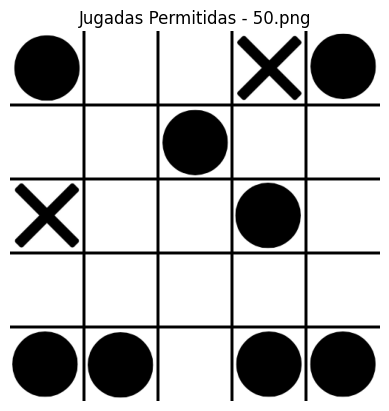

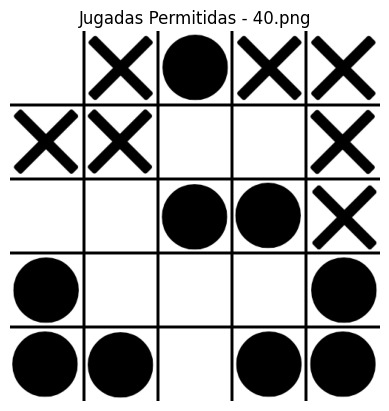

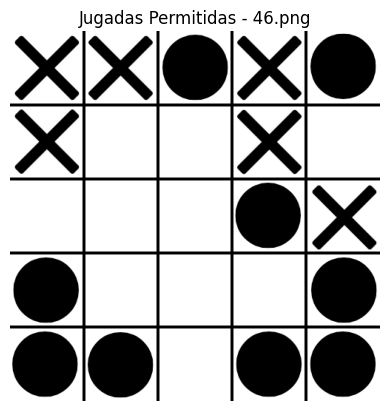

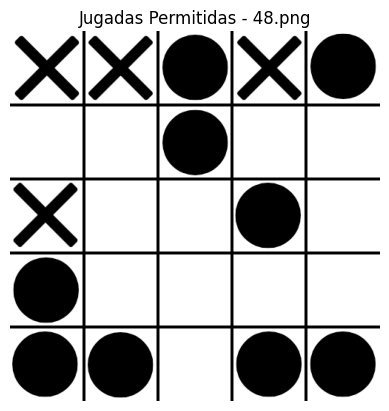


El directorio '/drive/My Drive/DATASET ALQUERQUE/No_permitidas/' no existe.


In [ ]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt

# Montar Google Drive en Colab
drive.mount('/content/drive')

# Especifica los nombres de los directorios
directorio_permitidas = '/content/drive/My Drive/DATASET ALQUERQUE/Permitidas/'
directorio_no_permitidas = '/content/drive/My Drive/DATASET ALQUERQUE/No_permitidas/'

# Función para mostrar imágenes en un directorio
def mostrar_imagenes(directorio, titulo):
    if os.path.exists(directorio):
        print(f"\nMostrando imágenes en '{directorio}':")
        for archivo in os.listdir(directorio):
            if archivo.lower().endswith('.png'):
                img_path = os.path.join(directorio, archivo)
                img = Image.open(img_path)
                plt.figure()
                plt.title(f"{titulo} - {archivo}")
                plt.imshow(img)
                plt.axis('off')
                plt.show()
    else:
        print(f"\nEl directorio '{directorio}' no existe.")

# Mostrar imágenes en los directorios especificados
mostrar_imagenes(directorio_permitidas, 'Jugadas Permitidas')
mostrar_imagenes(directorio_no_permitidas, 'Jugadas No Permitidas')


ELIMNANDO DUPLICADOS

Este código ahora usa únicamente el método SIFT para comparar imágenes y detectar duplicados.


Eliminando duplicados de los MOVIMIENTOS PERMTIDOS y moviendo a una nueva carpeta las imagenes que no estan duplicadas.

In [ ]:
from google.colab import drive
drive.mount('/drive') # Monta el sistema de archivos Google Drive en el entorno Colab para acceder a los archivos almacenados en él.

import cv2
import numpy as np
import os
from shutil import copy2
import matplotlib.pyplot as plt

def cargar_imagenes_de_carpeta(carpeta): # Define una función para cargar todas las imágenes de una carpeta específica.
    imagenes = [] # Inicializa una lista vacía para almacenar las imágenes cargadas.
    for nombre_archivo in os.listdir(carpeta): # Itera sobre todos los archivos en la carpeta especificada.
        ruta_img = os.path.join(carpeta, nombre_archivo) # Construye la ruta completa del archivo de imagen.
        img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE) # Lee la imagen en escala de grises.
        if img is not None: # Verifica si la imagen fue leída correctamente.
            imagenes.append((nombre_archivo, img)) # Agrega la imagen y su nombre al listado.
    return imagenes # Retorna la lista de imágenes cargadas.


def es_duplicado(img1, img2, umbral=0.75): # Función para determinar si dos imágenes son duplicados basándose en la detección de características SIFT.
    sift = cv2.SIFT_create() # Crea un detector de características SIFT.
    kp1, des1 = sift.detectAndCompute(img1, None) # Detecta y calcula las características de la primera imagen.
    kp2, des2 = sift.detectAndCompute(img2, None) # Detecta y calcula las características de la segunda imagen.
    bf = cv2.BFMatcher() # Crea un objeto BFMatcher para realizar coincidencias entre descripciones de características.
    matches = bf.knnMatch(des1, des2, k=2) # Encuentra las mejores coincidencias entre las descripciones de características de ambas imágenes.
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance] # Filtra las coincidencias que cumplen con un cierto umbral de similitud.
    return len(good_matches) / len(kp1) > umbral, len(good_matches) # Retorna si la imagen es un duplicado y el número de buenas coincidencias.


def procesar_imagenes(carpeta_origen, carpetas_comparacion, carpeta_destino, umbral=0.75, porcentaje_minimo=0.75): # Función principal que procesa las imágenes.
    print("Cargando imágenes...") # Imprime mensaje indicativo.
    imagenes_origen = cargar_imagenes_de_carpeta(carpeta_origen) # Carga las imágenes del origen.
    imagenes_comparacion = {carpeta: cargar_imagenes_de_carpeta(carpeta) for carpeta in carpetas_comparacion} # Carga las imágenes de comparación para cada carpeta especificada.

    print("Comparando imágenes...") # Imprime mensaje indicativo.
    para_mantener = [] # Lista para almacenar imágenes únicas.
    para_eliminar = set() # Conjunto para almacenar nombres de imágenes duplicadas.
    duplicados = [] # Lista para almacenar información sobre duplicados encontrados.

    total_comparaciones = len(imagenes_origen) * sum(len(comp_imgs) for comp_imgs in imagenes_comparacion.values()) # Calcula el total de comparaciones posibles.
    comparaciones_realizadas = 0 # Contador para las comparaciones realizadas.

    for nombre_src, src_img in imagenes_origen: # Itera sobre cada imagen del origen.
        encontrado_duplicado = False # Variable para indicar si se encuentra un duplicado.
        for carpeta, comp_imgs in imagenes_comparacion.items(): # Itera sobre cada carpeta de comparación.
            for nombre_comp, comp_img in comp_imgs: # Itera sobre cada imagen de comparación.
                es_dup, score = es_duplicado(src_img, comp_img, umbral) # Determina si la imagen es un duplicado.
                comparaciones_realizadas += 1 # Incrementa el contador de comparaciones.
                if es_dup: # Si se encuentra un duplicado.
                    encontrado_duplicado = True # Indica que se encontró un duplicado.
                    para_eliminar.add(nombre_src) # Agrega el nombre de la imagen del origen a eliminar.
                    duplicados.append((nombre_src, src_img, carpeta, nombre_comp, comp_img, score)) # Almacena información sobre el duplicado.
        if not encontrado_duplicado: # Si no se encontró ningún duplicado.
            para_mantener.append((nombre_src, src_img)) # Mantiene la imagen en la lista de para mantener.
        print(f"Comparaciones realizadas: {comparaciones_realizadas}/{total_comparaciones}") # Imprime el progreso de las comparaciones.

    conteo_original = len(imagenes_origen) # Conteo inicial de imágenes.
    conteo_para_mantener = len(para_mantener) # Conteo final de imágenes únicas.
    conteo_requerido_para_mantener = int(conteo_original * porcentaje_minimo) # Porcentaje mínimo requerido de imágenes para mantener.

    if conteo_para_mantener < conteo_requerido_para_mantener: # Verifica si se cumple el criterio mínimo de imágenes para mantener.
        raise ValueError(f"No hay suficientes imágenes después de la eliminación. Requerido: {conteo_requerido_para_mantener}, Encontrado: {conteo_para_mantener}") # Lanza error si no se cumplen los requisitos.

    if not os.path.exists(carpeta_destino): # Verifica si la carpeta destino existe.
        os.makedirs(carpeta_destino) # Crea la carpeta destino si no existe.

    for nombre_img, img in para_mantener: # Itera sobre las imágenes únicas para moverlas.
        ruta_src = os.path.join(carpeta_origen, nombre_img) # Construye la ruta de origen de la imagen.
        ruta_dst = os.path.join(carpeta_destino, nombre_img) # Construye la ruta de destino de la imagen.
        copy2(ruta_src, ruta_dst) # Copia la imagen al destino.

    print(f"Movido {len(para_mantener)} imágenes a '{carpeta_destino}' y eliminado {len(para_eliminar)} duplicados.") # Informa sobre el resultado de la operación.
    print("Comparación completa.") # Imprime mensaje indicativo de finalización.

    for nombre_src, src_img, carpeta_comp, nombre_comp, comp_img, score in duplicados: # Itera sobre los duplicados encontrados.
        plt.figure(figsize=(10, 5)) # Configura la figura para la visualización.
        plt.suptitle(f"Duplicado encontrado (SIFT score: {score:.2f})") # Título de la figura con el puntaje SIFT.

        plt.subplot(1, 2, 1) # Subplot para la imagen original.
        plt.title(f"Origen: {nombre_src}") # Título del subplot.
        plt.imshow(src_img, cmap='gray') # Visualiza la imagen original en escala de grises.
        plt.axis('off') # Oculta los ejes.

        plt.subplot(1, 2, 2) # Subplot para la imagen comparada.
        plt.title(f"Comparación: {nombre_comp} desde {carpeta_comp}") # Título del subplot.
        plt.imshow(comp_img, cmap='gray') # Visualiza la imagen comparada en escala de grises.
        plt.axis('off') # Oculta los ejes.

        plt.show() # Muestra la figura con las imágenes comparadas.


# Definir carpetas (actualizar estos caminos según sea necesario)
carpeta_origen = '/drive/My Drive/DATASET ALQUERQUE/Permitidas/'
carpetas_comparacion = [
    '/drive/My Drive/otros/g1/',
    '/drive/My Drive/otros/g2/',
    '/drive/My Drive/otros/g3/',
    '/drive/My Drive/otros/g4/',
    '/drive/My Drive/otros/g5/',
]
carpeta_destino = '/drive/My Drive/DATASET ALQUERQUE/Final/permitidos/'

# Procesar imágenes usando el método SIFT
procesar_imagenes(carpeta_origen, carpetas_comparacion, carpeta_destino)


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Cargando imágenes...
Comparando imágenes...
Comparaciones realizadas: 424/21200
Comparaciones realizadas: 848/21200
Comparaciones realizadas: 1272/21200
Comparaciones realizadas: 1696/21200
Comparaciones realizadas: 2120/21200
Comparaciones realizadas: 2544/21200
Comparaciones realizadas: 2968/21200
Comparaciones realizadas: 3392/21200
Comparaciones realizadas: 3816/21200
Comparaciones realizadas: 4240/21200
Comparaciones realizadas: 4664/21200
Comparaciones realizadas: 5088/21200
Comparaciones realizadas: 5512/21200
Comparaciones realizadas: 5936/21200
Comparaciones realizadas: 6360/21200
Comparaciones realizadas: 6784/21200
Comparaciones realizadas: 7208/21200
Comparaciones realizadas: 7632/21200
Comparaciones realizadas: 8056/21200
Comparaciones realizadas: 8480/21200
Comparaciones realizadas: 8904/21200
Comparaciones realizadas: 9328/21200
Comparaciones realizadas: 9752/

Eliminando duplicados de los MOVIMIENTOS NO PERMTIDOS y moviendo a una nueva carpeta las imagenes que no estan duplicadas.

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
Cargando imágenes...
Comparando imágenes...
Comparaciones realizadas: 424/21200
Comparaciones realizadas: 848/21200
Comparaciones realizadas: 1272/21200
Comparaciones realizadas: 1696/21200
Comparaciones realizadas: 2120/21200
Comparaciones realizadas: 2544/21200
Comparaciones realizadas: 2968/21200
Comparaciones realizadas: 3392/21200
Comparaciones realizadas: 3816/21200
Comparaciones realizadas: 4240/21200
Comparaciones realizadas: 4664/21200
Comparaciones realizadas: 5088/21200
Comparaciones realizadas: 5512/21200
Comparaciones realizadas: 5936/21200
Comparaciones realizadas: 6360/21200
Comparaciones realizadas: 6784/21200
Comparaciones realizadas: 7208/21200
Comparaciones realizadas: 7632/21200
Comparaciones realizadas: 8056/21200
Comparaciones realizadas: 8480/21200
Comparaciones realizadas: 8904/21200
Comparaciones realizadas: 9328/21200
Comparaciones realizadas: 9752/

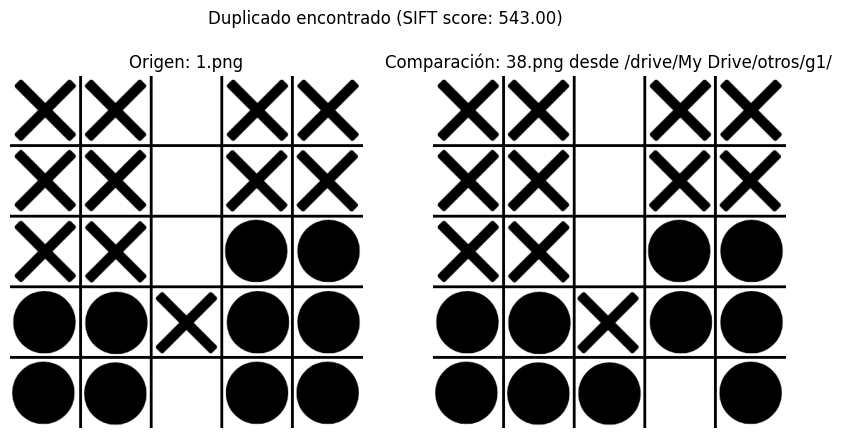

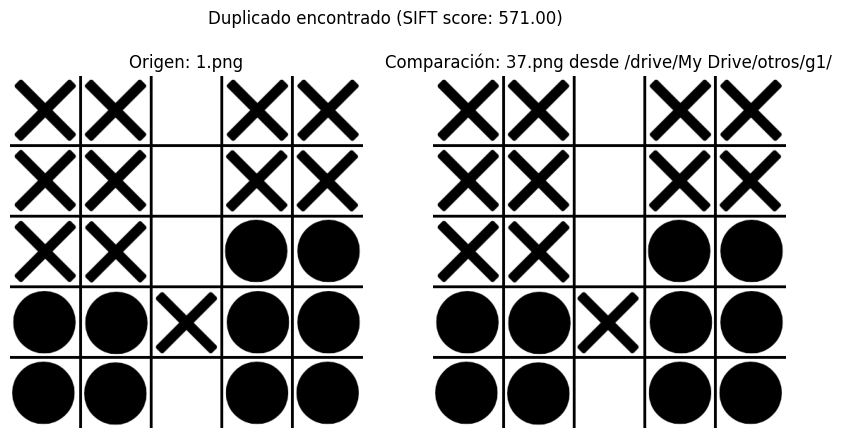

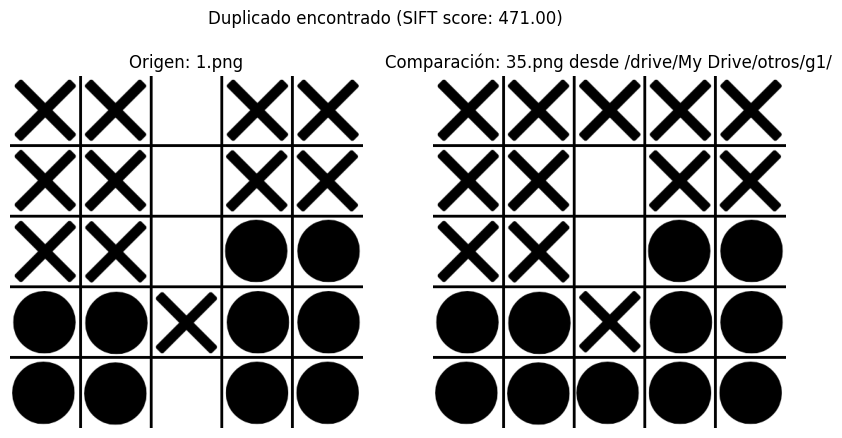

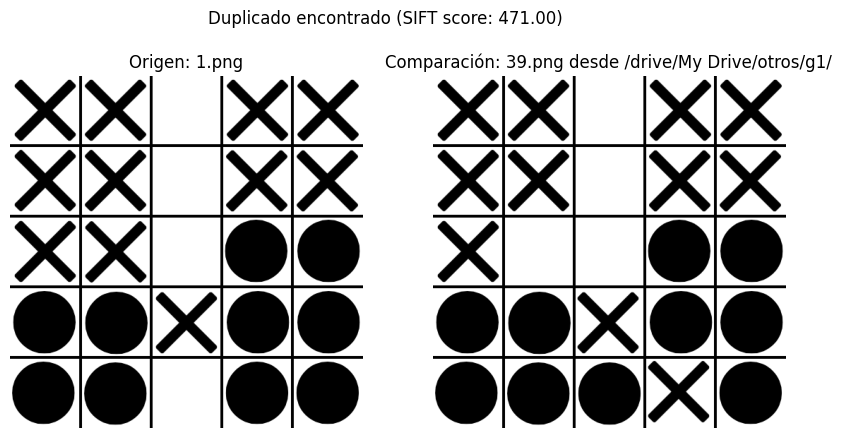

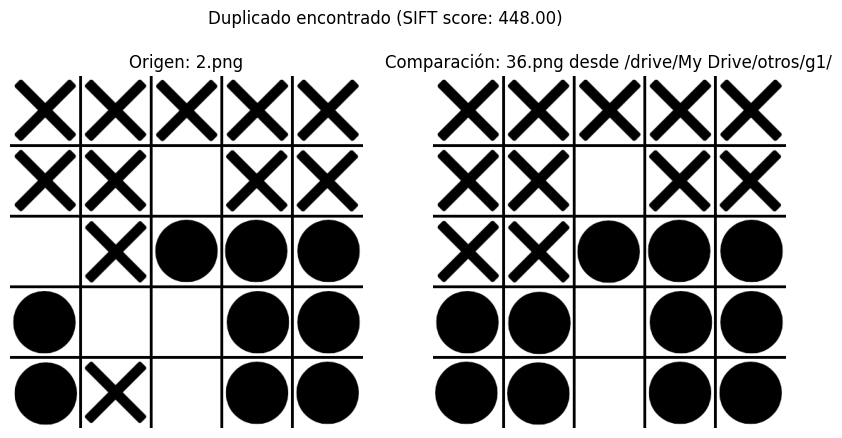

In [ ]:
from google.colab import drive
drive.mount('/drive') # Monta el sistema de archivos Google Drive en el entorno Colab para acceder a los archivos almacenados en él.

import cv2
import numpy as np
import os
from shutil import copy2
import matplotlib.pyplot as plt

def cargar_imagenes_de_carpeta(carpeta): # Define una función para cargar todas las imágenes de una carpeta específica.
    imagenes = [] # Inicializa una lista vacía para almacenar las imágenes cargadas.
    for nombre_archivo in os.listdir(carpeta): # Itera sobre todos los archivos en la carpeta especificada.
        ruta_img = os.path.join(carpeta, nombre_archivo) # Construye la ruta completa del archivo de imagen.
        img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE) # Lee la imagen en escala de grises.
        if img is not None: # Verifica si la imagen fue leída correctamente.
            imagenes.append((nombre_archivo, img)) # Agrega la imagen y su nombre al listado.
    return imagenes # Retorna la lista de imágenes cargadas.


def es_duplicado(img1, img2, umbral=0.75): # Función para determinar si dos imágenes son duplicados basándose en la detección de características SIFT.
    sift = cv2.SIFT_create() # Crea un detector de características SIFT.
    kp1, des1 = sift.detectAndCompute(img1, None) # Detecta y calcula las características de la primera imagen.
    kp2, des2 = sift.detectAndCompute(img2, None) # Detecta y calcula las características de la segunda imagen.
    bf = cv2.BFMatcher() # Crea un objeto BFMatcher para realizar coincidencias entre descripciones de características.
    matches = bf.knnMatch(des1, des2, k=2) # Encuentra las mejores coincidencias entre las descripciones de características de ambas imágenes.
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance] # Filtra las coincidencias que cumplen con un cierto umbral de similitud.
    return len(good_matches) / len(kp1) > umbral, len(good_matches) # Retorna si la imagen es un duplicado y el número de buenas coincidencias.


def procesar_imagenes(carpeta_origen, carpetas_comparacion, carpeta_destino, umbral=0.75, porcentaje_minimo=0.75): # Función principal que procesa las imágenes.
    print("Cargando imágenes...") # Imprime mensaje indicativo.
    imagenes_origen = cargar_imagenes_de_carpeta(carpeta_origen) # Carga las imágenes del origen.
    imagenes_comparacion = {carpeta: cargar_imagenes_de_carpeta(carpeta) for carpeta in carpetas_comparacion} # Carga las imágenes de comparación para cada carpeta especificada.

    print("Comparando imágenes...") # Imprime mensaje indicativo.
    para_mantener = [] # Lista para almacenar imágenes únicas.
    para_eliminar = set() # Conjunto para almacenar nombres de imágenes duplicadas.
    duplicados = [] # Lista para almacenar información sobre duplicados encontrados.

    total_comparaciones = len(imagenes_origen) * sum(len(comp_imgs) for comp_imgs in imagenes_comparacion.values()) # Calcula el total de comparaciones posibles.
    comparaciones_realizadas = 0 # Contador para las comparaciones realizadas.

    for nombre_src, src_img in imagenes_origen: # Itera sobre cada imagen del origen.
        encontrado_duplicado = False # Variable para indicar si se encuentra un duplicado.
        for carpeta, comp_imgs in imagenes_comparacion.items(): # Itera sobre cada carpeta de comparación.
            for nombre_comp, comp_img in comp_imgs: # Itera sobre cada imagen de comparación.
                es_dup, score = es_duplicado(src_img, comp_img, umbral) # Determina si la imagen es un duplicado.
                comparaciones_realizadas += 1 # Incrementa el contador de comparaciones.
                if es_dup: # Si se encuentra un duplicado.
                    encontrado_duplicado = True # Indica que se encontró un duplicado.
                    para_eliminar.add(nombre_src) # Agrega el nombre de la imagen del origen a eliminar.
                    duplicados.append((nombre_src, src_img, carpeta, nombre_comp, comp_img, score)) # Almacena información sobre el duplicado.
        if not encontrado_duplicado: # Si no se encontró ningún duplicado.
            para_mantener.append((nombre_src, src_img)) # Mantiene la imagen en la lista de para mantener.
        print(f"Comparaciones realizadas: {comparaciones_realizadas}/{total_comparaciones}") # Imprime el progreso de las comparaciones.

    conteo_original = len(imagenes_origen) # Conteo inicial de imágenes.
    conteo_para_mantener = len(para_mantener) # Conteo final de imágenes únicas.
    conteo_requerido_para_mantener = int(conteo_original * porcentaje_minimo) # Porcentaje mínimo requerido de imágenes para mantener.

    if conteo_para_mantener < conteo_requerido_para_mantener: # Verifica si se cumple el criterio mínimo de imágenes para mantener.
        raise ValueError(f"No hay suficientes imágenes después de la eliminación. Requerido: {conteo_requerido_para_mantener}, Encontrado: {conteo_para_mantener}") # Lanza error si no se cumplen los requisitos.

    if not os.path.exists(carpeta_destino): # Verifica si la carpeta destino existe.
        os.makedirs(carpeta_destino) # Crea la carpeta destino si no existe.

    for nombre_img, img in para_mantener: # Itera sobre las imágenes únicas para moverlas.
        ruta_src = os.path.join(carpeta_origen, nombre_img) # Construye la ruta de origen de la imagen.
        ruta_dst = os.path.join(carpeta_destino, nombre_img) # Construye la ruta de destino de la imagen.
        copy2(ruta_src, ruta_dst) # Copia la imagen al destino.

    print(f"Movido {len(para_mantener)} imágenes a '{carpeta_destino}' y eliminado {len(para_eliminar)} duplicados.") # Informa sobre el resultado de la operación.
    print("Comparación completa.") # Imprime mensaje indicativo de finalización.

    for nombre_src, src_img, carpeta_comp, nombre_comp, comp_img, score in duplicados: # Itera sobre los duplicados encontrados.
        plt.figure(figsize=(10, 5)) # Configura la figura para la visualización.
        plt.suptitle(f"Duplicado encontrado (SIFT score: {score:.2f})") # Título de la figura con el puntaje SIFT.

        plt.subplot(1, 2, 1) # Subplot para la imagen original.
        plt.title(f"Origen: {nombre_src}") # Título del subplot.
        plt.imshow(src_img, cmap='gray') # Visualiza la imagen original en escala de grises.
        plt.axis('off') # Oculta los ejes.

        plt.subplot(1, 2, 2) # Subplot para la imagen comparada.
        plt.title(f"Comparación: {nombre_comp} desde {carpeta_comp}") # Título del subplot.
        plt.imshow(comp_img, cmap='gray') # Visualiza la imagen comparada en escala de grises.
        plt.axis('off') # Oculta los ejes.

        plt.show() # Muestra la figura con las imágenes comparadas.


# Definir carpetas (actualizar estos caminos según sea necesario)
carpeta_origen = '/drive/My Drive/DATASET ALQUERQUE/No_permitidas/'
carpetas_comparacion = [
    '/drive/My Drive/otros/g1/',
    '/drive/My Drive/otros/g2/',
    '/drive/My Drive/otros/g3/',
    '/drive/My Drive/otros/g4/',
    '/drive/My Drive/otros/g5/',
]
carpeta_destino = '/drive/My Drive/DATASET ALQUERQUE/Final/no_permitidos/'

# Procesar imágenes usando el método SIFT
procesar_imagenes(carpeta_origen, carpetas_comparacion, carpeta_destino)


SEGMENTACION DE IMAGENES

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

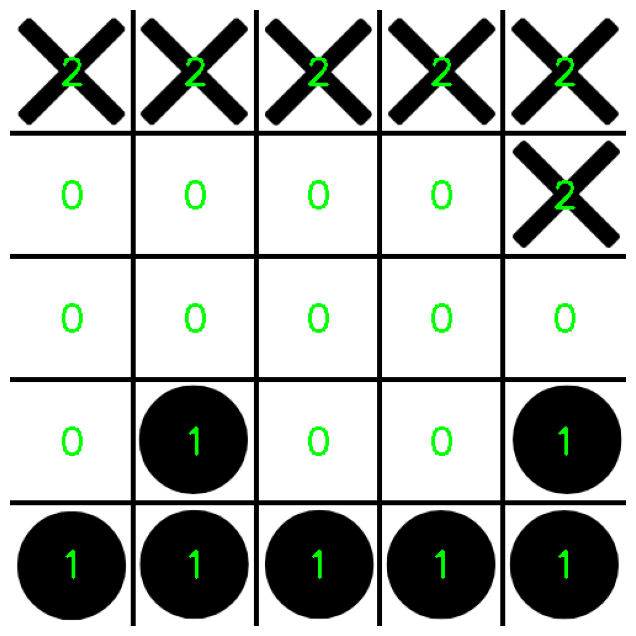

[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]


In [ ]:

################## SEGMENTACION - SIFT - MATCHES FINAL ####################
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import cv2
from skimage.feature import match_descriptors, SIFT

# Cargar la imagen
input_image_path = '7.png'
I = Image.open(input_image_path)

# Transformación a escala de grises
I1 = I.convert('L')
I2 = np.asarray(I1, dtype=np.float64)

# Vector unidimensionalidad
X = I2.reshape((-1, 1))

# Configuración K-means
k_means = KMeans(n_clusters=3)
k_means.fit(X)

# Extraemos el valor de los centroides y las etiquetas de cada pixel
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

# Reconstruimos la imagen utilizando las tres intensidades de los centroides
I2_compressed = np.choose(etiquetas, centroides.flatten())
I2_compressed.shape = I2.shape

# Normalizar los valores para asegurar que estén en el rango de 0 a 255
I2_compressed = (I2_compressed - np.min(I2_compressed)) / (np.max(I2_compressed) - np.min(I2_compressed)) * 255
I2_compressed = I2_compressed.astype(np.uint8)
I2_image = Image.fromarray(I2_compressed)

# Segmentar la imagen en celdas de 100x100 píxeles
cell_size = 100
cells = []

for i in range(5):
    for j in range(5):
        cell = I2_image.crop((j * cell_size, i * cell_size, (j+1) * cell_size, (i+1) * cell_size))
        cells.append(cell)

# Preparación de imágenes de referencia para círculos y cruces
ref_circle = cv2.imread('circulo.png', cv2.IMREAD_GRAYSCALE)
ref_cross = cv2.imread('equis.png', cv2.IMREAD_GRAYSCALE)

# Función para identificar piezas en una celda usando K-means y SIFT
def identify_piece(cell):
    cell_array = np.asarray(cell, dtype=np.float64).reshape(-1, 1)
    k_means = KMeans(n_clusters=3)
    k_means.fit(cell_array)
    centroides = k_means.cluster_centers_
    etiquetas = k_means.labels_

    # Convertir la celda a un formato compatible con OpenCV
    cell_cv = np.array(cell)
    if len(cell_cv.shape) == 2:  # Si es una imagen en escala de grises
        cell_cv = cv2.cvtColor(cell_cv, cv2.COLOR_GRAY2BGR)

    # Iniciar SIFT y detectar puntos clave y descriptores
    sift = cv2.SIFT_create()
    kp_cell, des_cell = sift.detectAndCompute(cell_cv, None)

    # Si no se detectan puntos clave, asumimos que la celda está vacía
    if des_cell is None or len(kp_cell) == 0:
        return 0  # Celda vacía

    # Detectar puntos clave y descriptores en imágenes de referencia
    kp_circle, des_circle = sift.detectAndCompute(ref_circle, None)
    kp_cross, des_cross = sift.detectAndCompute(ref_cross, None)

    # Matcher para comparar descriptores
    bf = cv2.BFMatcher()
    matches_circle = bf.knnMatch(des_cell, des_circle, k=2)
    matches_cross = bf.knnMatch(des_cell, des_cross, k=2)

    # Aplicar el ratio test para seleccionar las mejores coincidencias
    good_matches_circle = [m for m, n in matches_circle if m.distance < 0.90 * n.distance]
    good_matches_cross = [m for m, n in matches_cross if m.distance < 0.90 * n.distance]

    # Utilizar el número de buenas coincidencias para decidir si es círculo o cruz
    if len(good_matches_cross) > len(good_matches_circle):
        return 2  # Cruz
    else:
        return 1  # Círculo

# Identificar y etiquetar cada celda
result_labels = []

for cell in cells:
    label = identify_piece(cell)
    result_labels.append(label)

# Crear una nueva imagen con las etiquetas superpuestas
tablero_color = cv2.cvtColor(np.asarray(I1), cv2.COLOR_GRAY2BGR)

for i in range(5):
    for j in range(5):
        label = result_labels[i * 5 + j]
        text = str(label)
        cv2.putText(tablero_color, text, (j * cell_size + 40, i * cell_size + 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Mostrar la imagen con las etiquetas
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(tablero_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(result_labels)


Verificando matches

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


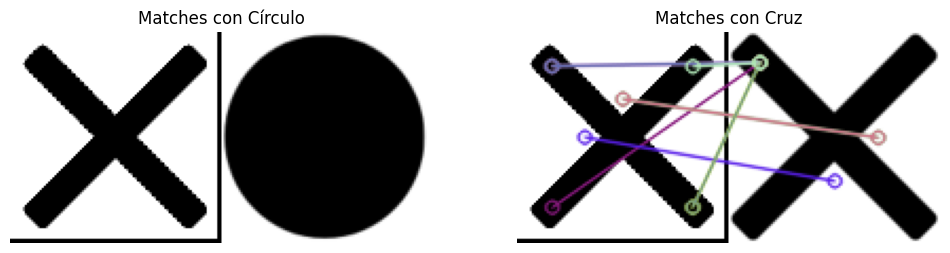

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


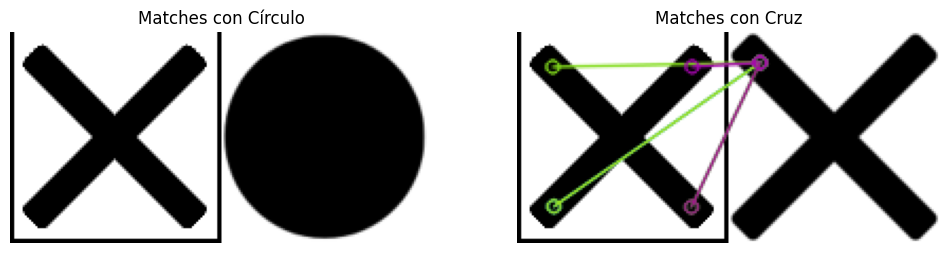

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


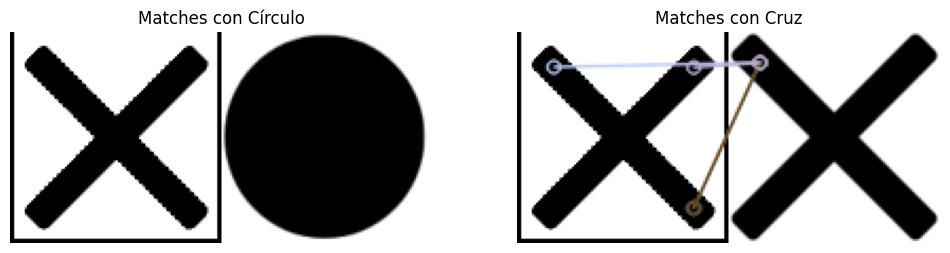

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


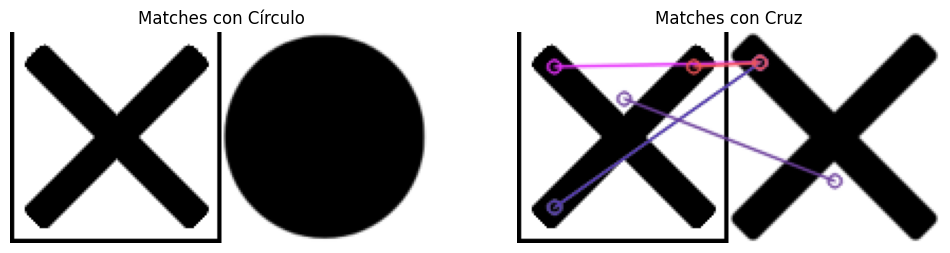

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


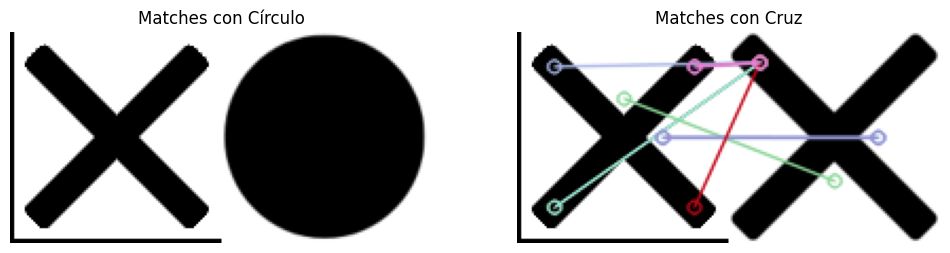

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *

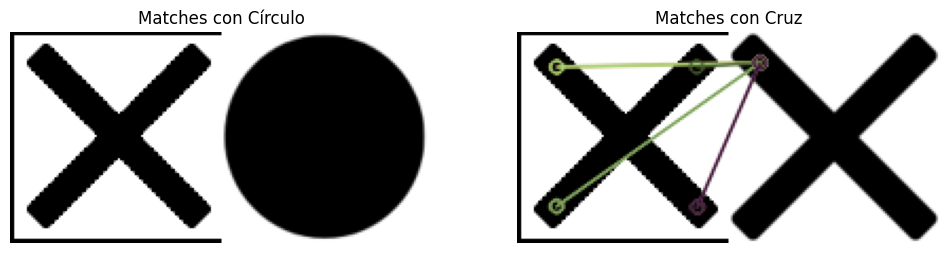

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *

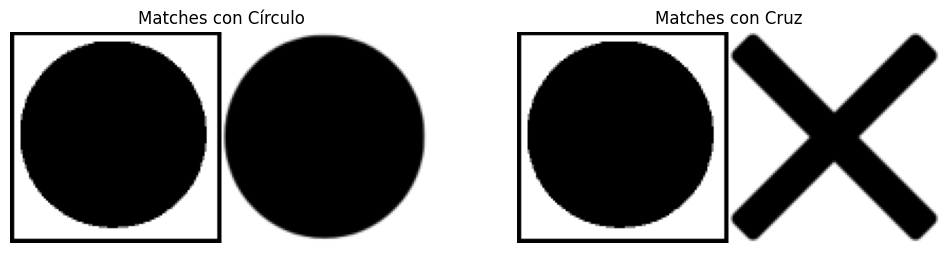

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *

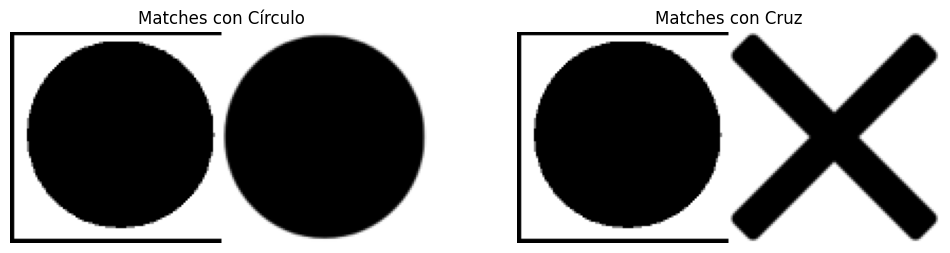

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


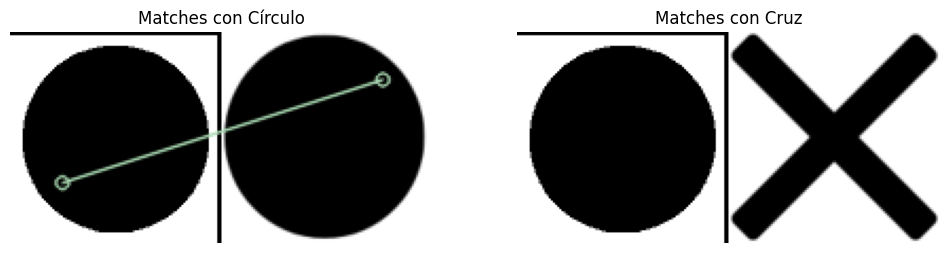

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


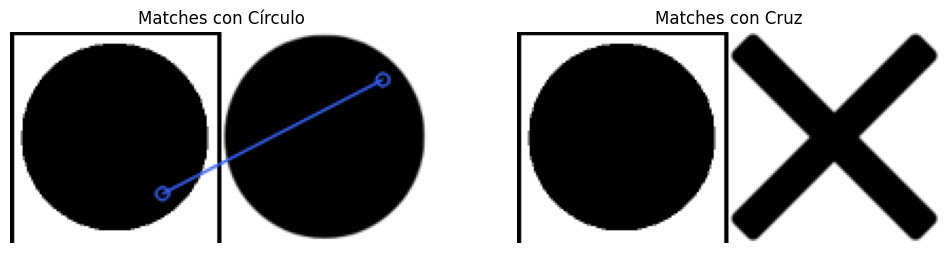

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


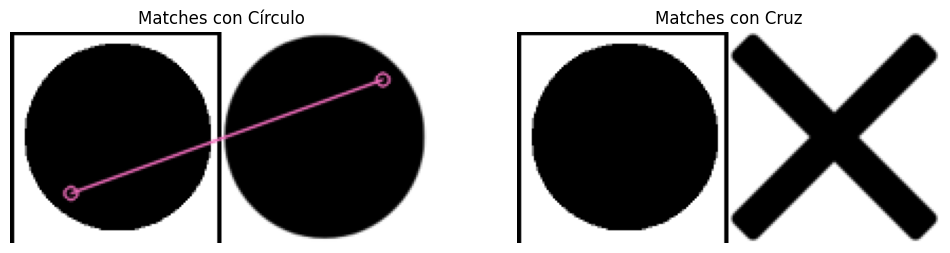

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


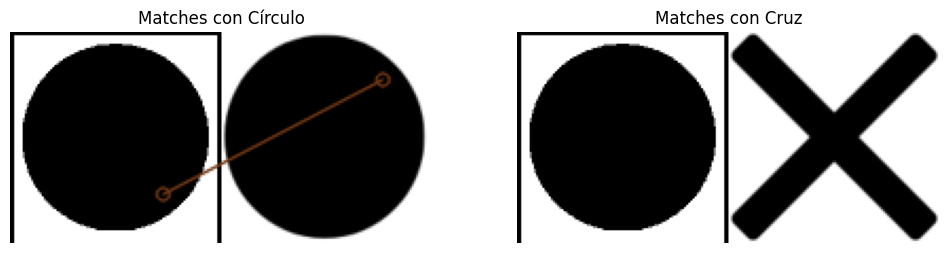

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


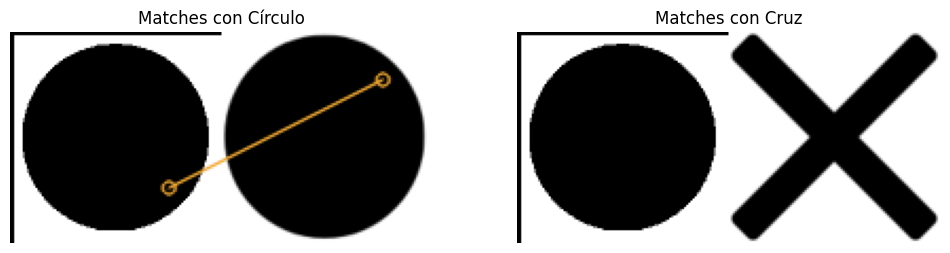

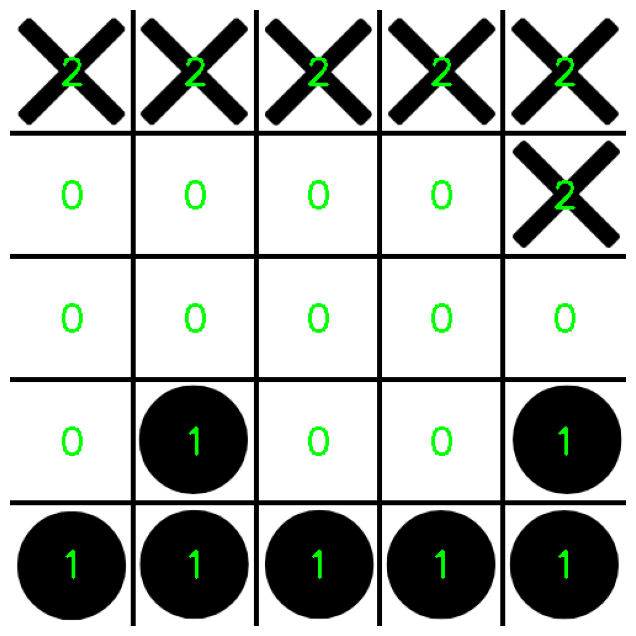

[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import cv2
from skimage.feature import match_descriptors, SIFT

# Cargar la imagen
input_image_path = '7.png'
I = Image.open(input_image_path)

# Transformación a escala de grises
I1 = I.convert('L')
I2 = np.asarray(I1, dtype=np.float64)

# Vector unidimensionalidad
X = I2.reshape((-1, 1))

# Configuración K-means
k_means = KMeans(n_clusters=3)
k_means.fit(X)

# Extraemos el valor de los centroides y las etiquetas de cada pixel
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

# Reconstruimos la imagen utilizando las tres intensidades de los centroides
I2_compressed = np.choose(etiquetas, centroides.flatten())
I2_compressed.shape = I2.shape

# Normalizar los valores para asegurar que estén en el rango de 0 a 255
I2_compressed = (I2_compressed - np.min(I2_compressed)) / (np.max(I2_compressed) - np.min(I2_compressed)) * 255
I2_compressed = I2_compressed.astype(np.uint8)
I2_image = Image.fromarray(I2_compressed)

# Segmentar la imagen en celdas de 100x100 píxeles
cell_size = 100
cells = []

for i in range(5):
    for j in range(5):
        cell = I2_image.crop((j * cell_size, i * cell_size, (j+1) * cell_size, (i+1) * cell_size))
        cells.append(cell)

# Preparación de imágenes de referencia para círculos y cruces
ref_circle = cv2.imread('circulo.png', cv2.IMREAD_GRAYSCALE)
ref_cross = cv2.imread('equis.png', cv2.IMREAD_GRAYSCALE)

# Función para identificar piezas en una celda usando K-means y SIFT
def identify_piece(cell):
    cell_array = np.asarray(cell, dtype=np.float64).reshape(-1, 1)
    k_means = KMeans(n_clusters=3)
    k_means.fit(cell_array)
    centroides = k_means.cluster_centers_
    etiquetas = k_means.labels_

    # Convertir la celda a un formato compatible con OpenCV
    cell_cv = np.array(cell)
    if len(cell_cv.shape) == 2:  # Si es una imagen en escala de grises
        cell_cv = cv2.cvtColor(cell_cv, cv2.COLOR_GRAY2BGR)

    # Iniciar SIFT y detectar puntos clave y descriptores
    sift = cv2.SIFT_create()
    kp_cell, des_cell = sift.detectAndCompute(cell_cv, None)

    # Si no se detectan puntos clave, asumimos que la celda está vacía
    if des_cell is None or len(kp_cell) == 0:
        return 0, None, None  # Celda vacía

    # Detectar puntos clave y descriptores en imágenes de referencia
    kp_circle, des_circle = sift.detectAndCompute(ref_circle, None)
    kp_cross, des_cross = sift.detectAndCompute(ref_cross, None)

    # Matcher para comparar descriptores
    bf = cv2.BFMatcher()
    matches_circle = bf.knnMatch(des_cell, des_circle, k=2)
    matches_cross = bf.knnMatch(des_cell, des_cross, k=2)

    # Aplicar el ratio test para seleccionar las mejores coincidencias
    good_matches_circle = [m for m, n in matches_circle if m.distance < 0.90 * n.distance]
    good_matches_cross = [m for m, n in matches_cross if m.distance < 0.90 * n.distance]

    # Mostrar los matches
    img_matches_circle = cv2.drawMatches(cell_cv, kp_cell, ref_circle, kp_circle, good_matches_circle, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    img_matches_cross = cv2.drawMatches(cell_cv, kp_cell, ref_cross, kp_cross, good_matches_cross, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Mostrar las imágenes con los matches
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_matches_circle, cv2.COLOR_BGR2RGB))
    plt.title('Matches con Círculo')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_matches_cross, cv2.COLOR_BGR2RGB))
    plt.title('Matches con Cruz')
    plt.axis('off')

    plt.show()

    # Utilizar el número de buenas coincidencias para decidir si es círculo o cruz
    if len(good_matches_cross) > len(good_matches_circle):
        return 2, img_matches_circle, img_matches_cross  # Cruz
    else:
        return 1, img_matches_circle, img_matches_cross  # Círculo

# Identificar y etiquetar cada celda
result_labels = []

for cell in cells:
    label, img_matches_circle, img_matches_cross = identify_piece(cell)
    result_labels.append(label)

# Crear una nueva imagen con las etiquetas superpuestas
tablero_color = cv2.cvtColor(np.asarray(I1), cv2.COLOR_GRAY2BGR)

for i in range(5):
    for j in range(5):
        label = result_labels[i * 5 + j]
        text = str(label)
        cv2.putText(tablero_color, text, (j * cell_size + 40, i * cell_size + 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Mostrar la imagen con las etiquetas
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(tablero_color, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(result_labels)
